# Automated DFT band interpolation via Wannierization

In this example we show how to obtain the DFT interpolated bands by means of the `aiida-wannier90` plugin.

In [1]:
from aiida import orm, load_profile
load_profile()

Profile<uuid='3745313b017b418697d37cbf16c4e7ef' name='generic'>

In [2]:
from aiida_wannier90_workflows.utils.workflows.builder.serializer import print_builder 
from aiida_wannier90_workflows.utils.kpoints import get_explicit_kpoints_from_mesh
from aiida_wannier90_workflows.utils.workflows.builder.setter import set_parallelization, set_num_bands, set_kpoints
from aiida_wannier90_workflows.utils.workflows.builder.submit import submit_and_add_group 
from aiida_wannier90_workflows.common.types import WannierProjectionType
from aiida_wannier90_workflows.workflows import Wannier90BandsWorkChain

## minimal inputs needed for protocols

In [3]:
import yaml,io

# Read YAML file
with open("../configuration/codes_localhost_yw90.yaml", 'r') as stream:
    codes = yaml.safe_load(stream)
    
with open("../configuration/resources_localhost.yaml", 'r') as stream:
    resources = yaml.safe_load(stream)

In [4]:
from aiida.orm import QueryBuilder
qb = QueryBuilder()
qb.append(orm.Group, filters={'label': 'Silicon/bulk'}, tag='group')
qb.append(orm.StructureData, with_group='group')

loaded_structure_id = qb.all()[0][0].pk

In [5]:
options = {
    'pseudo_family':"PseudoDojo/0.4/PBE/SR/standard/upf",
    'protocol':'fast',
    #'parent_id':274, #not necessary to set; if you want it, take ytheour previously nscf id (pk) to skip the DFT part.
    'structure_id':loaded_structure_id,
}

In [6]:
projections="analytic"

if projections=="analytic":
    wannier_projection_type=WannierProjectionType.ANALYTIC
else:
    WannierProjectionType.ATOMIC_PROJECTORS_QE 


In [7]:
builder = Wannier90BandsWorkChain.get_builder_from_protocol(
        codes=codes,
        structure=orm.load_node(options["structure_id"]),
        pseudo_family=options["pseudo_family"],
        protocol="fast",
        projection_type=wannier_projection_type,
    )

Summary of key input parameters:
  Formula: Si2
  PseudoFamily: PseudoDojo/0.4/PBE/SR/standard/upf
  ElectronicType: METAL
  SpinType: NONE
  WannierProjectionType: ANALYTIC
  WannierDisentanglementType: SMV
  WannierFrozenType: ENERGY_FIXED
  num_bands: 12
  num_wann: 8
  mp_grid: [5, 5, 5]



In [8]:
parallelization = dict(
    max_wallclock_seconds=24 * 3600,
    # num_mpiprocs_per_machine=48,
    #npool=4,
    num_machines=1,
)

set_parallelization(
    builder,
    parallelization=parallelization,
    process_class=Wannier90BandsWorkChain,
)


#### START computational resources settings.

builder['nscf']['pw']['metadata']['options'] = resources

builder['scf']['pw']['metadata']['options'] = resources

builder['pw2wannier90']['pw2wannier90']['metadata']['options'] = resources

builder['wannier90']['wannier90']['metadata']['options'] = resources

#### END computational resources settings.

In [9]:
# Use 4x4x4 kmesh
kpoints = get_explicit_kpoints_from_mesh(builder.structure, [8,8,8])
set_kpoints(builder, kpoints, process_class=Wannier90BandsWorkChain)

In [10]:
# START projections settings:
    
set_num_bands(
    builder=builder, 
    num_bands=14,                   # KS states used in the Wannierization
    #exclude_bands=range(1,5), 
    process_class=Wannier90BandsWorkChain)

params = builder.wannier90.wannier90.parameters.get_dict()

## START explicit atomic projections:
if projections=="analytic":

    del builder.projwfc
    builder.wannier90.auto_energy_windows = False
    builder.wannier90.shift_energy_windows = True
    params['num_wann'] = 8
    builder.wannier90.wannier90.projections = orm.List(list=['Si:s','Si:p'])
    params.pop('auto_projections', None) # Uncomment this if you want analytic atomic projections

    #
    # The following line can be also deleted.
    builder['pw2wannier90']['pw2wannier90']['parameters'] = orm.Dict(dict={'inputpp': {'atom_proj': False}})

## END explicit atomic projections:

# optional settings.
#params.pop('dis_proj_min', None)
#params.pop('dis_proj_max', None)
#params['num_wann'] = 16
#params['dis_froz_max'] = 2

params = orm.Dict(dict=params)
builder.wannier90.wannier90.parameters = params

# END projections settings.

In [11]:
print_builder(builder)

{'clean_workdir': False,
 'nscf': {'kpoints': '512 kpts<None>',
          'kpoints_force_parity': False,
          'pw': {'code': 'pw_develop@local_slurm<365>',
                 'metadata': {'options': {'max_wallclock_seconds': 3600,
                                          'prepend_text': 'export '
                                                          'OMP_NUM_THREADS=1',
                                          'resources': {'num_cores_per_mpiproc': 1,
                                                        'num_machines': 1,
                                                        'num_mpiprocs_per_machine': 1}}},
                 'parallelization': {'npool': 1},
                 'parameters': {'CONTROL': {'calculation': 'nscf',
                                            'etot_conv_thr': 0.0002,
                                            'forc_conv_thr': 0.001,
                                            'restart_mode': 'from_scratch',
                                        

### Computational resources

In [12]:
from aiida.engine import submit

In [13]:
run = None

In [14]:
if run:
    print('run is already running -> {}'.format(run.pk))
    print('sure that you want to run again?, if so, copy the else instruction in the cell below and run!')
else:
    run = submit(builder)

print(run)

uuid: 1da58b0c-67e7-46d9-945b-6a5c32ae4b73 (pk: 1441) (aiida.workflows:wannier90_workflows.bands)


In [29]:
!verdi process report {run.pk}

2024-02-19 16:59:14 [703 | REPORT]: [1441|Wannier90BandsWorkChain|run_seekpath]: launching seekpath: Si2 -> Si2
2024-02-19 16:59:15 [704 | REPORT]: [1441|Wannier90BandsWorkChain|run_scf]: launching PwBaseWorkChain<1449> in scf mode
2024-02-19 16:59:16 [705 | REPORT]:   [1449|PwBaseWorkChain|run_process]: launching PwCalculation<1452> iteration #1
2024-02-19 17:00:08 [706 | REPORT]:   [1449|PwBaseWorkChain|results]: work chain completed after 1 iterations
2024-02-19 17:00:08 [707 | REPORT]:   [1449|PwBaseWorkChain|on_terminated]: remote folders will not be cleaned
2024-02-19 17:00:08 [708 | REPORT]: [1441|Wannier90BandsWorkChain|run_nscf]: launching PwBaseWorkChain<1459> in nscf mode
2024-02-19 17:00:10 [709 | REPORT]:   [1459|PwBaseWorkChain|run_process]: launching PwCalculation<1462> iteration #1
2024-02-19 17:01:52 [710 | REPORT]:   [1459|PwBaseWorkChain|results]: work chain completed after 1 iterations
2024-02-19 17:01:52 [711 | REPORT]:   [1459|PwBaseWorkChain|on_terminated]: remot

## Plotting results

It is also possible to use the command line:

```bash
aiida-wannier90-workflows plot band 1441 # the Wannier90BandsWorkChain pk
```

In [30]:
import matplotlib.pyplot as plt

#last occupied band index.
b = 4 

w90_qe = run.outputs.band_structure

In [31]:
# Just a way to have nice plotting.

l_x = []
l_names = []
l_remove = []

for i in w90_qe.labels:
    if len(l_x)>0:
        if i[0] == l_x[-1]+1:
            if i[1] == 'GAMMA':
                l_names[-1] = l_names[-1]+"|$\Gamma$"
            else:
                l_names[-1] = l_names[-1]+"|"+i[1]
            l_remove.append(i[0])
        else:    
            l_x.append(i[0])
            if i[1] == 'GAMMA':
                l_names.append("$\Gamma$")
            else:
                l_names.append(i[1])
    else:    
        l_x.append(i[0])
        
        if i[1] == 'GAMMA':
            l_names.append("$\Gamma$")
        else:
            l_names.append(i[1])

In [32]:
w90bands = w90_qe.get_bands()

In [33]:
import numpy as np
for j in l_remove:
    w90bands = np.delete(w90bands, obj=j, axis=0)

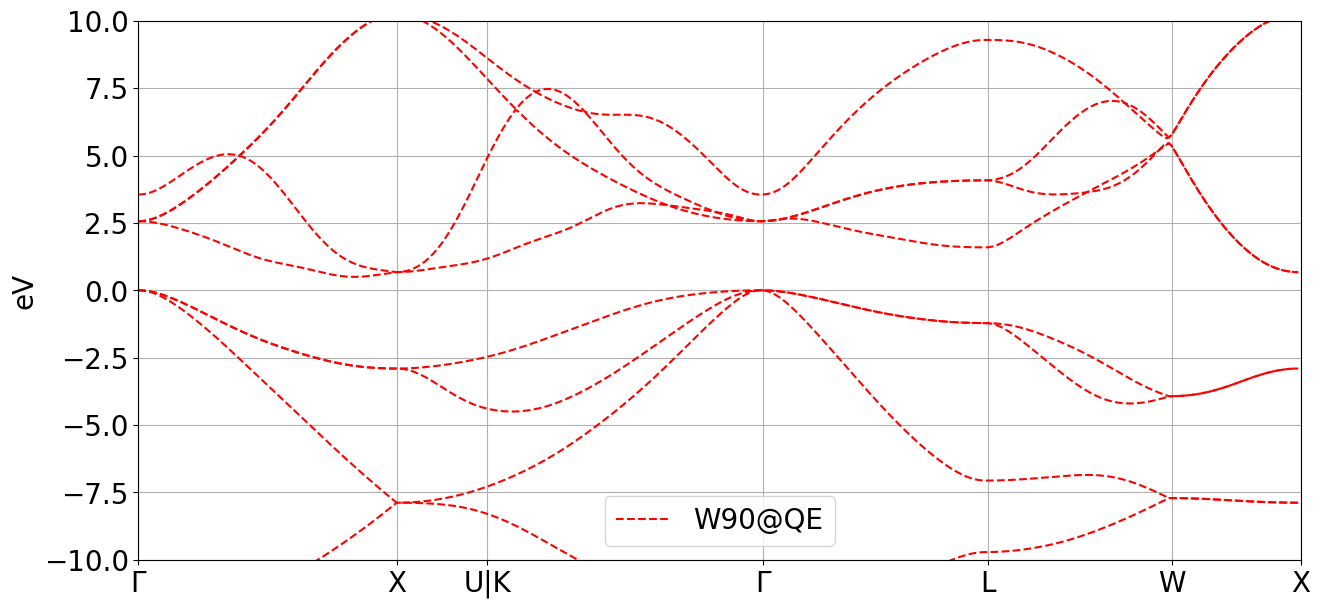

In [36]:
fig,ax=plt.subplots(figsize=[15,7])
plt.plot(w90bands-max(w90_qe.get_bands()[:,b-1]),'--',color='red')

plt.plot(w90bands[0,b-1]-max(w90_qe.get_bands()[:,b-1]),'--',color='red',label = 'W90@QE')
plt.ylim(-10,10)

plt.grid()
plt.xticks(l_x,l_names)
plt.tick_params(axis='both',labelsize=20)
plt.xlim(0,max(l_x))
plt.ylabel("eV",fontsize=20)
#plt.ylim(-2,5)
plt.legend(fontsize=20)

#plt.savefig('plot_.pdf')